In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install torch

   ---------------------------------------- 0.0/216.0 MB ? eta -:--:--
    --------------------------------------- 5.0/216.0 MB 25.1 MB/s eta 0:00:09
   -- ------------------------------------- 12.1/216.0 MB 29.0 MB/s eta 0:00:08
   --- ------------------------------------ 18.9/216.0 MB 32.1 MB/s eta 0:00:07
   ----- ---------------------------------- 27.8/216.0 MB 33.2 MB/s eta 0:00:06
   ------ --------------------------------- 36.4/216.0 MB 35.1 MB/s eta 0:00:06
   -------- ------------------------------- 45.9/216.0 MB 36.5 MB/s eta 0:00:05
   ---------- ----------------------------- 54.8/216.0 MB 37.1 MB/s eta 0:00:05
   ----------- ---------------------------- 63.4/216.0 MB 37.4 MB/s eta 0:00:05
   ------------- -------------------------- 70.8/216.0 MB 37.3 MB/s eta 0:00:04
   -------------- ------------------------- 78.9/216.0 MB 37.3 MB/s eta 0:00:04
   ---------------- ----------------------- 87.0/216.0 MB 37.5 MB/s eta 0:00:04
   ----------------- ---------------------- 95.7/2


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [5]:
import os
from PIL import Image

# Define paths
flip_dir = os.path.join('images', 'training', 'flip')
notflip_dir = os.path.join('images', 'training', 'notflip')

# Load images for 'flip'
flip_images = []
for filename in os.listdir(flip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(flip_dir, filename)
        img = Image.open(img_path)
        flip_images.append(img)

# Load images for 'notflip'
notflip_images = []
for filename in os.listdir(notflip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(notflip_dir, filename)
        img = Image.open(img_path)
        notflip_images.append(img)

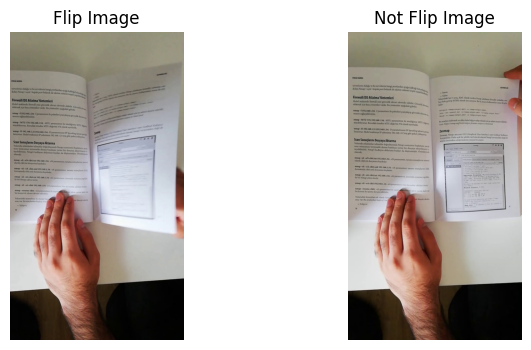

In [6]:
# Display one image from each category
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(flip_images[0])
plt.title('Flip Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(notflip_images[0])
plt.title('Not Flip Image')
plt.axis('off')

plt.show()

In [7]:
from random import shuffle

# Create labeled datasets
flip_dataset = [(img, 1) for img in flip_images]
notflip_dataset = [(img, 0) for img in notflip_images]

# Combine and shuffle
combined_dataset = flip_dataset + notflip_dataset
shuffle(combined_dataset)

In [8]:
combined_dataset[:5]  # Display the first 5 entries of the combined dataset

[(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 0),
 (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920>, 0)]

In [9]:
X = [img for img, label in combined_dataset]
y = [label for img, label in combined_dataset]

In [11]:
%pip install torchvision

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 18.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Custom dataset for PIL images and labels
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

# Create dataset and dataloader
dataset = ImageDataset(X, y, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create datasets and dataloaders for train and validation
train_dataset = ImageDataset(X_train, y_train, transform=transform)
val_dataset = ImageDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

Epoch 1/5 - Train Loss: 0.6466 - Val Loss: 0.3823 - Val Acc: 0.8706
Epoch 2/5 - Train Loss: 0.2643 - Val Loss: 0.1804 - Val Acc: 0.9415
Epoch 3/5 - Train Loss: 0.0951 - Val Loss: 0.0635 - Val Acc: 0.9833
Epoch 4/5 - Train Loss: 0.0738 - Val Loss: 0.0332 - Val Acc: 0.9875
Epoch 5/5 - Train Loss: 0.0589 - Val Loss: 0.0409 - Val Acc: 0.9833


In [20]:
# Define a CNN model with Global Average Pooling
class CNNWithGAP(nn.Module):
    def __init__(self):
        super(CNNWithGAP, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the new model
model_gap = CNNWithGAP().to(device)

In [22]:
model = CNNWithGAP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)